# Fourier Transform On Advection1d

In [6]:
import torch
import torch.nn as nn
import sys
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sys.path.append("../")

np.random.seed(0)
torch.manual_seed(0)
torch.set_printoptions(precision=16)

In [7]:
downsample_ratio = 1
n_train = 1000
n_test = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 100
base_lr = 0.001
scheduler = "OneCycleLR"
weight_decay = 1.0e-4
batch_size = 8
normalization_x = False
normalization_y = False
normalization_dim = []
config = {
    "train": {
        "base_lr": base_lr,
        "weight_decay": weight_decay,
        "epochs": epochs,
        "scheduler": scheduler,
        "batch_size": batch_size,
        "normalization_x": normalization_x,
        "normalization_y": normalization_y,
        "normalization_dim": normalization_dim,
    }
}


###################################
# load data
###################################
data_path = "../data/advection_1d/advection1d_ds4_n512_t1"

data = loadmat(data_path)
data_in = data["u"].T
data_out = data["v"].T
grid = data["grid"].T
print("data_in.shape:", data_in.shape)
print("data_out.shape:", data_out.shape)


data_in_ds = data_in[:, 0::downsample_ratio, np.newaxis]
data_out_ds = data_out[:, 0::downsample_ratio, np.newaxis]
grid_ds = grid[:, 0::downsample_ratio]


Nx = grid_ds.shape[1]
weights = np.zeros_like(grid_ds)
weights[:, 1:-1] = (grid_ds[:, 2:] - grid_ds[:, :-2]) / 2
weights[:, 0] = (grid_ds[:, 0] + grid_ds[:, 1]) / 2
weights[:, -1] = 1 - (grid_ds[:, -1] + grid_ds[:, -2]) / 2
mask = np.ones(Nx)

# x_train, y_train are [n_data, n_x, n_channel] arrays
x_train = torch.from_numpy(
    np.concatenate(
        (
            data_in_ds[0:n_train, :, :],
            grid_ds[0:n_train, :, np.newaxis],
            weights[0:n_train, :, np.newaxis],
            np.tile(mask, (n_train, 1))[:, :, np.newaxis],
        ),
        axis=2,
    ).astype(np.float32)
)
y_train = torch.from_numpy(data_out_ds[0:n_train, :, :].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
x_test = torch.from_numpy(
    np.concatenate(
        (
            data_in_ds[-n_test:, :, :],
            grid_ds[-n_test:, :, np.newaxis],
            weights[-n_test:, :, np.newaxis],
            np.tile(mask, (n_test, 1))[:, :, np.newaxis],
        ),
        axis=2,
    ).astype(np.float32)
)
y_test = torch.from_numpy(data_out_ds[-n_test:, :, :].astype(np.float32))
print("x_train.shape: ", tuple(x_train.shape))
print("y_train.shape: ", tuple(y_train.shape))

data_in.shape: (50000, 512)
data_out.shape: (50000, 512)
x_train.shape:  (1000, 512, 4)
y_train.shape:  (1000, 512, 1)


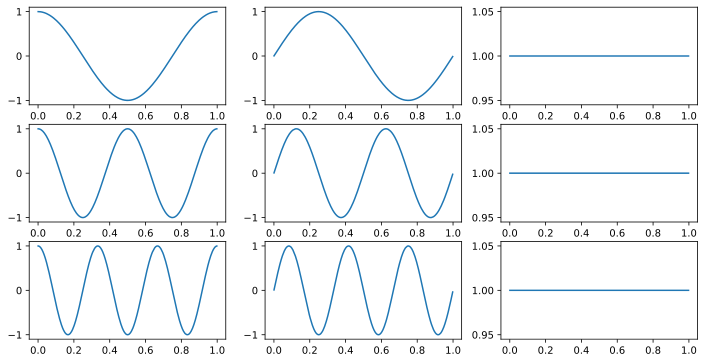

In [8]:
ndim = 1

L = 1.0
kx_max = 32  # (-32,...,32)
modes = 2 * np.pi * np.arange(1, kx_max + 1) / L
modes = torch.tensor(modes, dtype=torch.float).to(device)

x_train = x_train.to(device)
u = x_train[0, :, 0]

grid = x_train[0, :, 1]
weight = x_train[0, :, 2]
weight1 = 1 / 512

temp = torch.einsum("x,k->kx", grid, modes)
bases_c = torch.cos(temp)
bases_s = torch.sin(temp)
bases_0 = (x_train[0, :, 3])[np.newaxis, :]
wbases_c, wbases_s, wbases_0 = (
    bases_c * weight,
    bases_s * weight,
    bases_0 * weight,
)
wbases_c1, wbases_s1, wbases_01 = (
    bases_c * weight1,
    bases_s * weight1,
    bases_0 * weight1,
)

t = 3
fig1, ax1 = plt.subplots(ncols=3, nrows=t, figsize=(12, 2 * t))
for k in range(t):
    ax1[k, 0].plot(grid.cpu(), bases_c[k, :].cpu())
    ax1[k, 1].plot(grid.cpu(), bases_s[k, :].cpu())
    ax1[k, 2].plot(grid.cpu(), bases_0[0, :].cpu())

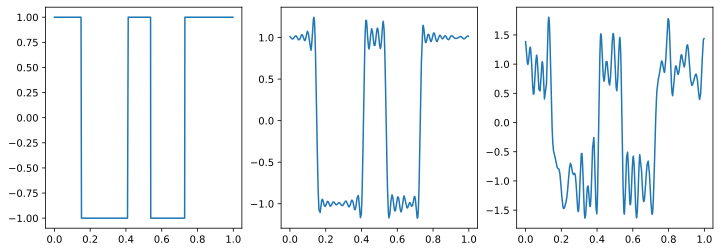

In [9]:
def forier_transform(u, wbases_c, wbases_s, wbases_0, bases_c, bases_s, bases_0):
    f_c_hat = torch.einsum("x,kx->k", u, wbases_c)
    f_s_hat = -torch.einsum("x,kx->k", u, wbases_s)
    f_0_hat = torch.einsum("x,kx->k", u, wbases_0)
    v = (
        torch.einsum("k,kx->x", f_0_hat, bases_0)
        + 2 * torch.einsum("k,kx->x", f_c_hat, bases_c)
        - 2 * torch.einsum("k,kx->x", f_s_hat, bases_s)
    )
    return v

v=forier_transform(u, wbases_c, wbases_s, wbases_0, bases_c, bases_s, bases_0)
v1=forier_transform(u, wbases_c1, wbases_s1, wbases_01, bases_c, bases_s, bases_0)

fig2, ax2 = plt.subplots(ncols=3, figsize=(12, 4))
ax2[0].plot(grid.cpu(), u.cpu())
ax2[1].plot(grid.cpu(), v.cpu())
ax2[2].plot(grid.cpu(), v1.cpu())

plt.show()